In [1]:
# The notebook's environment might not recognise local installs of ADRpy, fix that now...
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))

<img src="../img/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook is designed to walk the reader through ADRpy's constraint analysis capabilities in the context of an example, that of a twin engine, supersonic fighter prototype.*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as uc
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Constraint Analysis of the Northrop YF-17A

<img src="https://www.dfrc.nasa.gov/Gallery/Photo/YF-17/Large/EC76-5270.jpg" width="40%" align="right" style="border-left:20px solid white">

The Northrop YF-17A "Cobra" is a prototype, twin-engine, supersonic fighter - built to compete in the United States Air Force's Lightweight Fighter program.
It would ultimately lose to the General Dynamics F-16 Fighting Falcon, but find its way into the United States Navy as a precursor to the F/A-18 multi-role naval platform.

In an ideal case we'd like to extract performance parameters for the purposes of constraints analysis from official sources, such as a Pilot's Operating Handbook.
In many cases, unfortunately, this often means accessing proprietary or restricted-access information on performance.

Luckily for us, maths does not lie.
Provided with some well educated guesses and information that *is* public, it should be possible to reverse engineer something close to the Cobra's performance.

## Defining the Aircraft Concept

*For brevity, some user-definable parameters have been omitted - but a full list of parameters is available in the class documentation for `AircraftConcept`.
In addition, ambiguity in the details of the flight configurations of military aircraft for given performance specifications make analysis very unreliable - often, the best we can do is take educated guesses. **This maskes analysing military fighter concepts much harder** than commercial or older aircraft.
The analysis that follows is the author's best interpretation of likely design conditions.*

An aircraft concept can be instantiated with the following objects:
- Design mission brief dictionary
- Concept design (geometry) dictionary
- Concept performance (coefficients) dictionary
  
And optionally:
- Design atmosphere object (International Standard, MIL-HDBK, etc.)
- Propulsion system object

### High-confidence Design Parameters

> High confidence parameters are those aspects of the design in which we are fairly certain that reported numbers are accurate.
> These parameters have been lifted from reputable sources, or are echoed by many sources.
> Of course as with anything - just because lots of people are saying it, doesn't always mean it's true or hasn't been twisted in some way.
> For example, knowing an aircraft's maximum true airspeed isn't always the complete story, if we don't know what at which altitude this was achieved.
> We expect these aspects of a concept's design and performance to stay static or consistent through concept evaluation, and are critical to reverse engineering the aircraft's performance.

The easiest objects to define are that of the standard design atmosphere, and we may expect to use a turbojet.

In [3]:
# International Standard Atmosphere, 0 degree Kelvin temperature offset
designatm = at.Atmosphere()

designpropulsion = "Turbojet"

Strictly speaking the YF-17's General Electric YJ101 engines do have bypass flow with a ratio of 0.25:1.
This was, however, more for cooling than thrust generation - leading to the engine affectionately being referred to as more of a "leaky turbojet" than a true turbofan.

In the case of the YF-17, we can use NASA public-domain technical papers (like [[1]](#References)) to help profile the aircraft geometry.
Wikipedia is *not* a substitute for a high-quality source of information, but in the absence of information, sometimes we can't afford to be this picky.
Let's try and build our concept from what we find generally on the internet ([[1-5]](#References) and other less-reliable sources not listed).

In [4]:
# Reports of the Cobra achieving top speed of Mach 1.95 at its cruising altitude
VMO = uc.mps_kts(designatm.Mach_TAS(1.95, altitude_m=40e3))

designbrief = {
    "cruisealt_m": uc.ft_m(40e3), "cruisespeed_ktas": VMO,  # Cruise (top speed!)
    "cruisethrustfact": 1.00,                               # Cruise throttle setting @ISA
    "servceil_m": uc.ft_m(50e3)                             # Service ceiling
}

There are two problems with the above constraints:
1) We don't know anything about the configuration of the aircraft in either constraint. Was the aircraft carrying any stores or armament? What was the fuel state of the aircraft? Were there any under-wing pylons attached to the vehicle? From the perspective of a Northrop team trying to sell this concept to the USAF, it is perhaps unlikely that in any performance trials the YF-17 would have had any equipment or loadout that would be detrimental to the agility of the aircraft. Maybe Northrop is putting their best foot forward against General Dynamics, not shooting themselves in it by over-encumbering the aircraft.
2) The service ceiling constraint is incomplete. Not only do we not know the speed at which the service ceiling constraint is satisfied, we can't be sure how far above 50,000 feet the Cobra can fly. Numbers seem to suggest "50,000+ feet," whatever this means. Is that 50,010? 53,000? 58,420?...

For the rest of the aircraft analysis to make sense we will now assume that the Cobra's clean configuration is without external stores or payload (except for wingtip mounted sidewinder missiles), i.e. the aircraft will **not** be flown in any configuration that will result in the design MTOW being achieved.

*This will have implications on the analysis, which are discussed shortly.*

In [5]:
MTOW_lbf = 34_348           # Assuming full internal fuel + 2 AIM-9 wingtip missiles + 2 drop tanks
EMTW_lbf = 17_196           # Empty weight of the Cobra
JP8_dens = 7.0              # Fuel density (lbf / US gallon)
FPU8A_USgal = 330.0         # Drop tank capacity
droptank_lbf = (
    JP8_dens * FPU8A_USgal  # Weight of JP8 fuel in tank
    + 90                    # Weight of 330 gallon tank body
    + 240                   # Weight of hardpoint attachment (under-wing pylon)
)
TOW_lbf = MTOW_lbf - 2 * droptank_lbf  # MTOW minus 2 drop tanks == TOW to consider


print(f"YF-17 @(MTOW - 2 drop tanks)..: {TOW_lbf:,.0f} [lbf]")
print(f"YF-17 @(MTOW).................: {MTOW_lbf:,.0f} [lbf]")
print(f"Weight fraction (TOW / MTOW)..: {TOW_lbf / MTOW_lbf:.2%}")

YF-17 @(MTOW - 2 drop tanks)..: 29,068 [lbf]
YF-17 @(MTOW).................: 34,348 [lbf]
Weight fraction (TOW / MTOW)..: 84.63%


> 📝 **NOTE**: While we could simply use the `weightfractions` entry in the concept design definition dictionary to account for the allowable take-off weight without drop tanks, this is a dishonest representation of the aircraft.
> Allowing MTOW to exist as a mathematical possibility implies that the aircraft concept's `CDmin` should be relevant for the take-off constraint with the maximum equipment load (and the associated penalty to zero-lift drag), and reduce dynamically for the other constraints (if the tanks are dropped as they might be in a dogfight, or never loaded to begin with in flight-test speed trials).
> `CDmin` is constant for a concept in ADRpy, and so for different configurations of the aircraft's externals it's best to create multiple `AircraftConcept` objects that each represent a loadout, their respective take-off weights, and `CDmin` values.

The basic wing planform geometry of an aircraft can be very easily determined from:
1) Online reporting, manufacturer brochures, etc.
2) ... and/or pixel measurements and trigonometry of drawings
3) ... and/or operating Handbooks (for ground crew handling)

In [6]:
# Aspect ratio = wingspan ** 2 / wingarea
#    b / c     =    b ^ 2      / (b * c)
wingarea_m2 = 32.52
wingspan_m = 10.67
aspectratio = wingspan_m ** 2 / wingarea_m2

designdefinition = {
    "weight_n": uc.lbf_N(TOW_lbf),  
    "sweep_le_deg": 26.64, "sweep_25_deg": 20,
    "aspectratio": aspectratio,
}

### Intermediate-confidence Design Parameters

> Intermediate-confidence parameters are those which you are unlikely to find direct sources for online, but with some hand-waving you can probably get the ballpark numbers for.
> For example, you may obtain performance coefficients based on ancestral/sibling/derivative aircraft, or from those aircraft of similar type or mission.

We can learn a lot from the kinds of aerofoils in use on aircraft similar to the concept's type.
According to [[3]](#References), the Boeing F/A-18 Hornet (derived from the YF-17) uses *modified* NACA 6A-series aerofoils of 5% and 3.5% thickness at wing root and wing tip positions, respectively.
The nomenclature of NACA 6-series aerofoils as presented in [[4]](#References) suggest that the designations of 'NACA 65A005 mod' and 'NACA 65A003.5 mod' tell us that both of the Hornet's aerofoils have their minimum pressure at the mid-chord position (first digit following the "6" series designation meaning 50% chord) and have a "design lift coefficient in tenths" of zero (first digit following the "A").
This means the coefficient of lift at which the minimum drag condition is achieved is very close to zero:

$$
\text{Boeing F/A-18 Hornet} \, \textemdash
\begin{cases}
&\text{NACA 65A005 mod} & \, \longrightarrow \, & \text{
\textcolor{red}{NACA 6}\textcolor{blue}{5}\textcolor{red}{A}\textcolor{magenta}{0}\textcolor{teal}{05} \textcolor{orange}{mod}
}& \\
&\text{NACA 65A003.5 mod} & \, \longrightarrow \, & \text{
\textcolor{red}{NACA 6}\textcolor{blue}{5}\textcolor{red}{A}\textcolor{magenta}{0}\textcolor{teal}{03.5} \textcolor{orange}{mod}
}& \\
\end{cases}
$$

$$
\begin{eqnarray}
\textcolor{red}{\text{NACA aerofoil series}}: & \quad & \text{NACA }\textcolor{red}{\text{6A}}\\
\textcolor{blue}{\text{Minimum pressure location}}: & \quad & \textcolor{blue}{5}0\% \text{chord-wise distance behind LE}\\
\textcolor{magenta}{\text{CL of minimum drag}}: & \quad & C_{\text{L,minD}} = 0.\textcolor{magenta}{0}\\
\textcolor{teal}{\text{Thickness/chord ratio}}: & \quad & \textcolor{teal}{5.0}\%, \,\, \textcolor{teal}{3.5}\%\\
\textcolor{orange}{\text{Modified from nominal profile}}: & \quad & \text{Aerofoil is }\textcolor{orange}{\text{mod}}\text{ified}
\end{eqnarray}
$$

In [7]:
designperformance = {"CLminD": 0.0}

Next we consider the performance of the wings - which we must derive from the constituent aerofoils.
In this case
we do not know what modifications were made to the aerofoil geometry, but if we approximate their performance from NACA 63A010 and 64A010 in [[4]](#References), we find  $C_{\text{L,max}} \sim 0.8$ and when a 20% chord split flap is simulated at 60$^{\circ}$ deployment $C_{\text{L,max}} \sim 1.8$.

The introduction of flaps can generally be though of as a means of adding camber to a wing, which naturally raises the lift coefficient.
Figures in [[4]](#References) also show how the use of a split flap causes the wing to stall at an earlier angle of attack - i.e., flow separation is more likely (which should make intuitive sense).
The Cobra also uses slats which serve as a means of introducing camber near the leading edge and re-energising the flow over the front of the wing.
This has the effect of delaying stall and increasing $C_{\text{L,max}}$.

Assuming the slats further raise $C_{\text{L,max}} \sim 2.2$, the total effect of high-lift devices in a fully deployed configuration is to have the effect of $\Delta C_{\text{L,max}} = +1.4$ on section-wise lift.
To determine the effect on 3D $C_{\text{L,max}}$, we'll penalise the vanilla aerofoil and high-lift devices by 20% for

$$
C_{\text{L,max (3D)}} =
\begin{cases}
0.64 \quad \text{(vanilla)}   \\
1.76 \quad \text{(high-lift)}
\end{cases}
$$

The phases of flight which most demand lift-augmentation are take-off and landing.
However, the high-lift configuration is also high-drag - which makes it often unsuitable for take-off.
A quick assumption for performance in the take-off configuration (if an aircraft is capable of it) is to use performance equivalent to 50% of the high-lift system's capacity ($C_{\text{L,max}}^{\text{TO}} \sim 1.2$). 

> 📝 **NOTE**: It's worth being clear about what is meant by "clean" stall speeds and performance coefficients.
> ADRpy defines a clean configuration as that which pilot interacts with in normal cruising and climbing flight, which may or may not include the automatic actuation of aerodynamic surfaces.
> In the context of modern military fighter aircraft this means without the deliberate preparation of the aircraft for take-off or landing, but possibly including *high-lift device scheduling* in which onboard air-data computers intelligently deploy flaps and slats.
> The Cobra is one of many fighters to employ a scheduler to reduce pilot workload, and a prototype schedule is included in [[1]](#References).

The high-lift device scheduling of the Cobra means we can also approximate ($C_{\text{L,max}} \sim 1.2$) in clean configured flight.

In [8]:
CLmax2D = 0.8   # Clean aerofoils
dCLmax2D = 1.4  # Flaps + Slats delta

penalty = 0.8                               # 2D to 3D penalty
CLmax3D = (CLmax2D) * penalty               # Clean wing
CLmax3DHL = (CLmax2D + dCLmax2D) * penalty  # Flaps + Slats wing

# The vanilla wing with high-lift scheduling performs the same as the take-off
# configuration's maximum, which is 50% of the 3D wing's maximum lift capacity
CLmax3D = CLmax3DTO = (CLmax3D + CLmax3DHL) * 0.5

print(f"Without scheduling..: CLmax = {CLmax3D:.2f}")
print(f"With scheduling.....: CLmax = {CLmax3DTO:.2f}")
print(f"Landing config......: CLmax = {CLmax3DHL:.2f}")

designperformance.update({
    "CLmax": CLmax3D,
    "CLmaxTO": CLmax3DTO,
    "CLmaxHL": CLmax3DHL
})

Without scheduling..: CLmax = 1.20
With scheduling.....: CLmax = 1.20
Landing config......: CLmax = 1.76


> 📝 **NOTE**: The $C_{\text{L,max}}$ of the aircraft is a lot greater than that of the main wing, thanks to its leading-edge root extensions (LERX).
> The relevance of LERX here is very little, as this applies to extreme angle-of-attack manoeuvres and low speed flight.
> Constraints analysis techniques used here preferentially focus on steady-state flight conditions.
> As of writing, the only exception to this rule is the take-off constraint (out of cruise, service ceiling climb, climb, take-off, and **sustained** turn) - the accuracy of the take-off constraint suffers for it.


The YF-17, from which the F/A-18 Hornet is derived, likely shares many features and ballpark performance figures.
Various online sources place the Hornet's landing speed between 130-140 KCAS, depending on the weight.
Given that we are analysing a lighter than usual Hornet but we also want a higher speed to maintain level 1g flight instead of steady descent, we'll take 145 KCAS as an estimate for the stall speed of the Hornet (and therefore our Cobra concept) in clean (no stores/weapons) configuration.

Of course we can also compute the 1g stall speed directly from our estimated $C_{\text{L,max}}$, however, choosing reasonable values for both parameters and verifying concept compliance with the stall constraint.

In [9]:
print("We guess that the YF-17 Cobra should stall in 1g flight around 145.0 KCAS")

stall_vcas = (2 * (designdefinition["weight_n"] / wingarea_m2) / (designatm.airdens_kgpm3(0) * CLmax3D)) ** 0.5
stall_kcas = uc.mps_kts(stall_vcas)

print(f"...the computed stall speed of the YF-17 Cobra in 1g flight is {stall_kcas:.1f} KCAS")

designbrief["vstallclean_kcas"] = stall_kcas  # Clean stall speed, 1g

We guess that the YF-17 Cobra should stall in 1g flight around 145.0 KCAS
...the computed stall speed of the YF-17 Cobra in 1g flight is 143.0 KCAS


### Low-confidence Design Parameters

> A low-confidence design parameter isn't necessarily a parameter we are completely clueless on.
> Estimates are increasingly based on assumptions and guess-work.
> Theoretically as part of designing a new concept, you as the designer should have a relatively good idea of your performance targets and values.
> If reverse engineering an aircraft, these are the parameters you should fine tune (most helpfully with the assistance of a constraints diagram).

Minimum drag coefficient is obtained by comparing with similar aircraft of the era (`CDmin` $\in [0.12, 0.21]$) and fine-tuning the constraints plot with respect to any high-confidence constraints (such as our cruise requirement).

In [10]:
 designperformance["CDmin"] = 0.021

NASA standard 3001 [[6]](#References) shows that an average "non-deconditioned (to Earth's gravity)" human may withstand  $\sim60\text{m}/\text{s}^2$ vertical acceleration for about 10 seconds.
Clearly, the forces on a pilot during a dogfight are incredibly strenuous.
Modern-day fighter pilots train extensively and with the aid of 'G-suits' to withstand vertical, compressive acceleration during combat turns.

$$ n_{\text{st}} \times g =\frac{V^2}{r_{\text{turn}}}$$

For a given load factor, decreasing the designed turning speed results in tighter turn radii and quicker time-to-turn. This is advantageous in one-circle (nose-to-nose) fighting where the slower aircraft requires less angular displacement than a faster aircraft to bring its nose to bear on the bandit. Additionally, the higher rate-of-turn is favourable in two-circle (nose-to-tail) fighting where one aircraft must out-rate(-of-turn) the bandit.

On the other hand, increasing the designed turning speed improves the overall energy state of the aircraft. Reduced $C_{\text{L}}$ demand creates a large margin to $C_{\text{L,max}}$ that may be "cashed in" for instantaneous turn performance in snapshot opportunities. Furthermore, a more energetic aircraft has the option to trade speed for position (altitude) by conducting out-of-plane maneuveurs or climbs that a less energetic, pursuing bandit may not even be able to follow.

In [11]:
def turn_params(vturn_mps, gload):
    """Given turn speed and g-force, compute (turn_radius, turn_time, turn_rate)."""
    rturn_m = vturn_mps ** 2 / (gload * 9.81)   # radius of turn = v^2 / acc.
    circumference = 2 * np.pi * rturn_m         # circumference of turn
    tturn_s = circumference / vturn_mps         # time to complete 1 revolution
    omega_radps = 360 / tturn_s                 # angular rate

    return rturn_m, tturn_s, omega_radps

We're not sure what the YF-17 is capable of with regards to turn performance, so we'll make some guesses:

In [12]:
# Assume a pilot can withstand a constant 6.5G load
hst = 500
Vst = designatm.Mach_TAS(0.56, altitude_m=hst)
nst = 6.5
rst, tst, ost = turn_params(Vst, nst)

print("YF-17 Cobra turn performance:")
print("-" * 30)
print(f"Speed in turn.....: {uc.mps_kts(Vst):>4.0f} [ktas]")
print(f"Pilot G-forces....: {nst:>4.1f} [-]")
print(f"Radius of turn....: {rst:>4.0f} [m]")
print(f"Time to turn......: {tst:>4.1f} [s]")
print(f"Degrees per second: {ost:>4.1f} [deg/s]")

YF-17 Cobra turn performance:
------------------------------
Speed in turn.....:  368 [ktas]
Pilot G-forces....:  6.5 [-]
Radius of turn....:  563 [m]
Time to turn......: 18.7 [s]
Degrees per second: 19.3 [deg/s]


We can visualise what this performance means in a wider context using turn performance (from simple harmonic motion) and constant kinetic + gravitational potential energy diagrams:

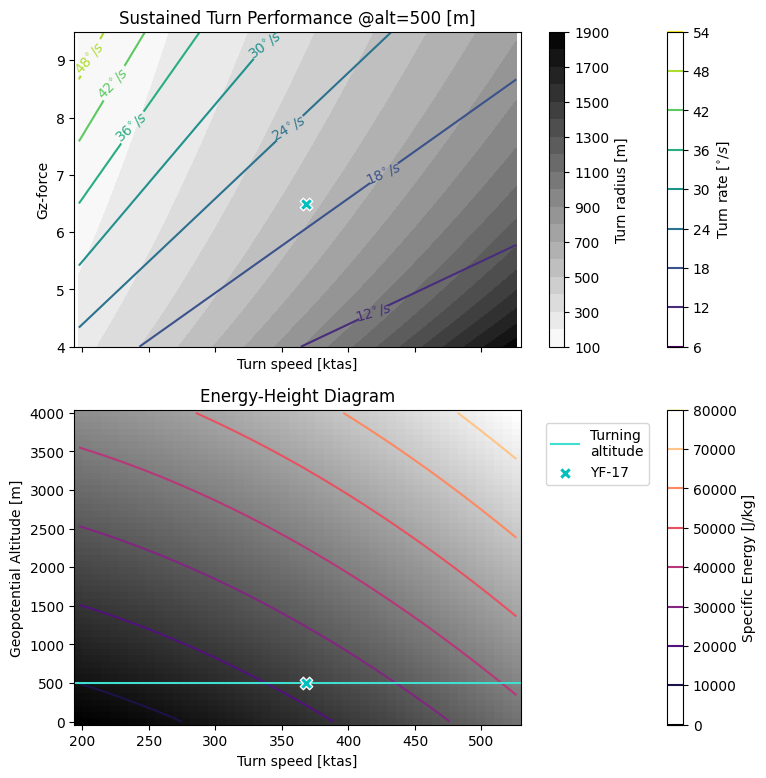

In [13]:
# Sweep the following Mach numbers and G-force at the given altitude
mach = np.linspace(0.3, 0.8)
speed = designatm.Mach_TAS(mach, altitude_m=hst)
gforce = np.linspace(4, 9.5)

# Create a 2D array of speeds and G-forces, to compute turn radius, time, and rate
V, G = np.meshgrid(speed, gforce)
RT, TT, OT = turn_params(vturn_mps=V, gload=G)

# Create plot
fig, axs = plt.subplots(2, figsize=(9, 9), sharex=True)
axs[0].set_title(f"Sustained Turn Performance @alt={hst:,} [m]")
axs[1].set_title("Energy-Height Diagram")
axs[0].set_xlabel("Turn speed [ktas]")
axs[1].set_xlabel("Turn speed [ktas]")
axs[0].set_ylabel("Gz-force")
axs[1].set_ylabel("Geopotential Altitude [m]")

# Plot the contour lines (turn rate)
cs = axs[0].contour(uc.mps_kts(V), G, OT, cmap="viridis")
fmt = lambda x: f"{x:.0f}" + r"$^{\circ}/s$"
axs[0].clabel(cs, cs.levels, inline=True, fmt=fmt)
fig.colorbar(cs, ax=axs[0], label="Turn rate [$^{\\circ}/s$]")

# Plot the filled contours (turn radius)
cm = axs[0].contourf(uc.mps_kts(V), G, RT, levels=20, cmap="binary")
fig.colorbar(cm, ax=axs[0], label="Turn radius [m]")

# Sweep the following altitudes for the potential energy plot
altitudes = np.linspace(0, 4e3)
V, H = np.meshgrid(speed, altitudes)

# Compute specific potential energy
E_m = 9.81 * H + 0.5 * V ** 2
axs[1].pcolormesh(uc.mps_kts(V), H, E_m, cmap="binary_r")
cs = axs[1].contour(uc.mps_kts(V), H, E_m, cmap="magma")
fig.colorbar(cs, ax=axs[1], label="Specific Energy [J/kg]")

# Plot the turning altitude used in the first plot
axs[1].axhline(hst, c="turquoise", label="Turning\naltitude")

# Plot the YF-17 Cobra's parameters
axs[0].scatter(uc.mps_kts(Vst), nst, marker="X", fc="c", ec="w", s=80)
axs[1].scatter(uc.mps_kts(Vst), hst, marker="X", fc="c", ec="w", s=80, label="YF-17", zorder=10)

# get the bounds of ax1 and ax2
x1, y1, w1, h1 = axs[0].get_position().bounds
x2, y2, w2, h2 = axs[1].get_position().bounds
# set ax2 location and size from ax1
axs[1].set_position([x2, y2, w1, h2])

# Finish up
axs[1].legend(bbox_to_anchor=(1.04, 0.98), loc="upper left")

plt.show()

In the figures above, we show for a given altitude the advantage of low-speed flight (better turn performance) against the pros of high-speed flight (better energy state).
The USAF ultimately settled on the YF-16 as the more promising of the Lightweight Fighters demonstrated.
Reclining the pilot's seat by $30^{\circ}$ helped to reduce the effective G-load experienced by the pilot, permitting a higher design turn speed and energy state (about 420-450 knots) while retaining exceptional turn performance.

Northrop's Cobra is no pushover though - one can see that for a constant turn rate, moving at a higher speed necessarily worsens turn radius.
Anecdotal evidence places the F/A-18 Hornet is only slightly worse in turn rate than the F-16 Fighting Falcon, and so for competitive two-circle performance Cobra/Hornet, the superior turn radius makes the Hornet family much better one-circle fighters.
The incorporation of LERX in the design make it clear that the Cobra's design is reflective of Northrop's focus upon expanding this strong low-speed performance, using vortex lift to create very large margins to $C_{\text{L,max}}$ and instantaneous turn performance competitive with best delta wing fighters.

There are presently no means of analysing instantaneous turn performance or vortex lift directly in this library, and so we don't include any performance parameters that reflect the Cobra's maximum serviceable angle of attack (which very often exceeds 40 degrees).

### The concept so far...

In [14]:
import json

print(json.dumps(designbrief, indent=4))
print(json.dumps(designdefinition, indent=4))
print(json.dumps(designperformance, indent=4))

{
    "cruisealt_m": 12192.0,
    "cruisespeed_ktas": 1203.9853676309644,
    "cruisethrustfact": 1.0,
    "servceil_m": 15240.0,
    "vstallclean_kcas": 142.9694789288808
}
{
    "weight_n": 129300.87318568207,
    "sweep_le_deg": 26.64,
    "sweep_25_deg": 20,
    "aspectratio": 3.5008886838868385
}
{
    "CLminD": 0.0,
    "CLmax": 1.2000000000000002,
    "CLmaxTO": 1.2000000000000002,
    "CLmaxHL": 1.7600000000000002,
    "CDmin": 0.021
}


With the above assumptions, the following remaining parameters are estimated and hand-iterated (using the constraint analysis diagram in the next section) for a YF-17 Cobra with afterburner engaged.

In [15]:
# Completed constraints for service ceiling, climb, and sustained turn
designbrief.update({
    "servceil_m": uc.ft_m(50e3), "secclimbspd_kias": 150,                     # Service ceiling
    "climbalt_m": 0, "climbspeed_kias": 320, 'climbrate_fpm': 30e3,           # Climb
    "turnalt_m": hst, "turnspeed_ktas": uc.mps_kts(Vst), "stloadfactor": nst  # Sustained turn
})

# Reverse engineer internal fuel capacity
fa18f_fuel_lbf = 10_860
yf17_fuel_lbf = fa18f_fuel_lbf - 4_460

# Made-up weight fractions to coax constraint curves towards the design point
designdefinition.update({
    "weightfractions": {
        "servceil": (EMTW_lbf + 0.85 * yf17_fuel_lbf) / TOW_lbf,  # Carry equivalent of 85% fuel in service ceiling climb
        "turn": (EMTW_lbf + 0.85 * yf17_fuel_lbf) / TOW_lbf       # Carry equivalent of 85% fuel in sustained turn
    }
})

print(json.dumps(designbrief, indent=4))
print(json.dumps(designdefinition, indent=4))
print(json.dumps(designperformance, indent=4))

{
    "cruisealt_m": 12192.0,
    "cruisespeed_ktas": 1203.9853676309644,
    "cruisethrustfact": 1.0,
    "servceil_m": 15240.0,
    "vstallclean_kcas": 142.9694789288808,
    "secclimbspd_kias": 150,
    "climbalt_m": 0,
    "climbspeed_kias": 320,
    "climbrate_fpm": 30000.0,
    "turnalt_m": 500,
    "turnspeed_ktas": 368.333089888551,
    "stloadfactor": 6.5
}
{
    "weight_n": 129300.87318568207,
    "sweep_le_deg": 26.64,
    "sweep_25_deg": 20,
    "aspectratio": 3.5008886838868385,
    "weightfractions": {
        "servceil": 0.7787257465253887,
        "turn": 0.7787257465253887
    }
}
{
    "CLminD": 0.0,
    "CLmax": 1.2000000000000002,
    "CLmaxTO": 1.2000000000000002,
    "CLmaxHL": 1.7600000000000002,
    "CDmin": 0.021
}


## Plotting a Constraint Diagram

Plotting diagram simply involves:
1. Creating an `AircraftConcept` object.
2. Calling the concept's `plot_constraints` method with target wing loadings to obtain matplotlib `fig` and `ax` objects.
3. Modifying the plot as necessary, and using `plt.show()`.

C:\Users\yr3g17\PycharmProjects\ADRpy_yaseen\src\ADRpy\constraintanalysis.py:1813: RuntimeWarning: Concept's 'groundrun_m' attribute is undefined
  groundrun_m = kwargs.get("groundrun_m", self.brief.groundrun_m)


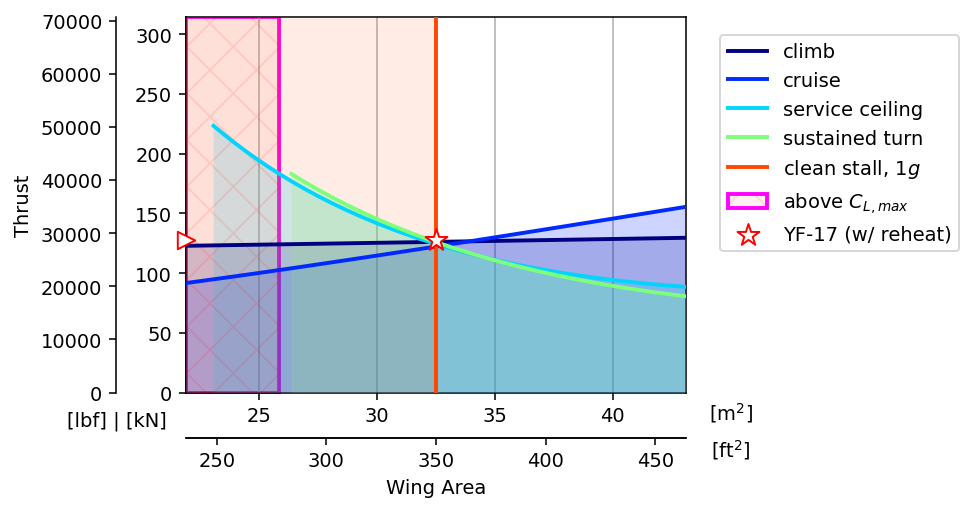

In [16]:
# Create the aircraft concept
concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdefinition,
    performance=designperformance,
    atmosphere=designatm,
    propulsion=designpropulsion
)

# Setup for the plot
wslist_pa = np.arange(3000, 6000, 100)
YJ101_wetthrust_N = 2 * uc.lbf_N(14.4e3)
common = {"fc": "white", "clip_on": False, "zorder": 100}

# Create the plot
fig, ax = concept.plot_constraints(wslist_pa, methods={"cdi_factor": "Raymer"})
xaxis_limit_l, _ = ax.get_xlim()
ax.scatter(xaxis_limit_l, YJ101_wetthrust_N, marker=">", ec="r", s=80, **common)
ax.scatter(wingarea_m2, YJ101_wetthrust_N, marker="*", ec="r", s=140, label="YF-17 (w/ reheat)", **common)
ax.remake_legend()  # Refresh the legend with this custom method
plt.show()

Just so it's clear - it shouldn't be surprising that all the lines pass through the design point here.
We revisit low-confidence parameters multiple times while writing the notebook to tune the constraint diagram - the process itself based on a great many assumptions about the Cobra's performance and configuration, and by no means does this notebook endorse the accuracy of this approach or any sources used.

We show that it is possible to analyse supersonic fighters in ADRpy, but with great difficulty when information is not readily available.

# References

[1] Sisk, T. R. and Matheny N. W., "TP1677 Precision Controllability of the YF-17 Airplane," NASA, 1980. Accessed: 07/03/2024. [Online]. Available: https://ntrs.nasa.gov/api/citations/19800014838/downloads/19800014838.pdf.

[2] "Northrop YF-17 (Cobra)," Military Factory. Accessed: 09/03/2024. [Online]. Available: https://www.militaryfactory.com/aircraft/detail.php?aircraft_id=271

[3] Lednicer, D., "The Incomplete Guide to Airfoil Usage," UIUC Applied Aerodynamics Group, 2023. Accessed: 09/03/2024. [Online]. Available: https://m-selig.ae.illinois.edu/ads/aircraft.html.

[4] Abbott, I. H., "NACA-TR-824 Summary of Aerofoil Data," NACA, 1945. Accessed: 09/03/2024. [Online]. Available: https://ntrs.nasa.gov/citations/19930090976.

[5] Loftin, L. K. Jr, "Theoretical and Experimental Data for a Number of NACA 6A-Series Airfoil Sections," NASA, 1946. Accessed 09/03/2024. [Online]. Available: https://ntrs.nasa.gov/citations/20050092351.

[6] "NASA Spaceflight Human-System Standard Volume 2: Human Factors, Habitability, and Environmental Health," NASA, 2013. Accessed 10/03/2024. [Online]. Available: https://standards.nasa.gov/standard/NASA/NASA-STD-3001-VOL-2, p60.